In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o-mini")


## Output Schema with TypedDict, Pydantic

In [2]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """ User Profile schema with typed fields """
    user_name: str
    interests: List[str]


In [5]:
user_profile: UserProfile = {
    "user_name": "Hrithik",
    "interests": ["biking", "technology", "coffee"]
}

print(user_profile)
print(type(user_profile))

{'user_name': 'Hrithik', 'interests': ['biking', 'technology', 'coffee']}
<class 'dict'>


In [6]:
import uuid
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

user_id = "1"
namespace_for_memory = (user_id, "memory")

key = "user_profile"
value = user_profile

in_memory_store.put(namespace_for_memory, key, value)


In [11]:
from pprint import pprint
for m in in_memory_store.search(namespace_for_memory):
    pprint(m.dict())

{'created_at': '2025-01-07T03:53:03.436552+00:00',
 'key': 'user_profile',
 'namespace': ['1', 'memory'],
 'score': None,
 'updated_at': '2025-01-07T03:53:03.436554+00:00',
 'value': {'interests': ['biking', 'technology', 'coffee'],
           'user_name': 'Hrithik'}}


In [18]:
profile = in_memory_store.get(namespace_for_memory, key)
pprint(profile.value)

{'interests': ['biking', 'technology', 'coffee'], 'user_name': 'Hrithik'}


## Using Pydantic and with_structured_output

In [20]:
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

structured_llm = llm.with_structured_output(UserProfile)

structured_output = structured_llm.invoke([HumanMessage(content="Hi, my name is Hrithik, I like to bike")])

print(structured_output)
print(type(structured_output))

{'user_name': 'Hrithik', 'interests': ['biking']}
<class 'dict'>


In [31]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.store.base import BaseStore
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from typing import Dict


class UserProfile(TypedDict):
    """ User Profile schema with typed fields """
    user_name: str
    interests: List[str]

class ChatBotState(MessagesState):
    memory : UserProfile = Field(..., description="User's Profile stored in the memory store")


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """ Load the memory from the store and use it to generate a personalized response """

    print("*****************************CALL MODEL NODE*****************************")


    user_id = config["configurable"]["user_id"]
    namespace_for_memory = (user_id, "memory")
    key = "user_memory"

    existing_memory = store.get(namespace_for_memory, key)

    if existing_memory:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'unknown')}\n"
            f"Interests: {', '.join(memory_dict, 'interests',[])}\n"
        )
    else:
        formatted_memory = None

    print(f"Formatted Memory: {formatted_memory}")
    print("---------------------------------------------------")


    MODEL_SYSTEM_MESSAGE = """
    You are a helpful assistant with memory that provides information about the user to answer questions.
    If you have memory about the user, use it to provide personalized responses to user's questions.
    Here is the memory (it may be empty): {memory}
    """

    system_message = SystemMessage(content=MODEL_SYSTEM_MESSAGE)

    response = llm.invoke([system_message] + state['messages'])

    print(f"Response: {response}")
    print("---------------------------------------------------")

    return {"messages" : [response]}


def write_memory(state: ChatBotState, config: RunnableConfig, store: BaseStore):
    """ Reflect on the chat history and save meory to the store """

    print("*****************************WRITE MEMORY NODE*****************************")

    user_id = config["configurable"]["user_id"]
    namespace_for_memory = (user_id, "memory")
    key = "user_memory"
    
    
    existing_memory = store.get(namespace_for_memory, key)
    if existing_memory:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests',[]))}\n"
        )
    else:
        formatted_memory = None

    print(f"Formatted Memory: {formatted_memory}")
    print("---------------------------------------------------")

    CREATE_MEMORY_SYSTEM_MESSAGE = """
    You are a helpful assistant that can create or update the user's memory based on the chat history.
    This will be saved for long term memory. If there is an existing memory, simply update it.
    Here is the existing memory (it may be empty): {memory}
    """

    system_message = SystemMessage(content=CREATE_MEMORY_SYSTEM_MESSAGE)
    new_memory = structured_llm.invoke([system_message] + state['messages'])

    print(f"New Memory: {new_memory}")
    print("---------------------------------------------------")

    store.put(namespace_for_memory, key, new_memory)

    return {"memory" : new_memory}

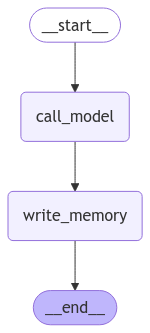

In [32]:
builder = StateGraph(ChatBotState)

builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

within_thread_memory = MemorySaver()
across_thread_memory = InMemoryStore()

graph = builder.compile(checkpointer = within_thread_memory, store = across_thread_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [33]:
thread = {"configurable" : {"user_id" : "1", "thread_id" : "1"}}

input_message = HumanMessage(content="Hi, my name is Hrithik, I like to bike round Austin and visit coffee shops")

for event in graph.stream({"messages":[input_message]}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Hrithik, I like to bike round Austin and visit coffee shops
*****************************CALL MODEL NODE*****************************
Formatted Memory: None
---------------------------------------------------
Response: content='Hi Hrithik! It’s great to meet you! Biking around Austin sounds like a fun way to explore the city. Do you have any favorite coffee shops that you like to visit after your rides?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 83, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None} id='run-6e36d250-daa2-4bf3-87

In [36]:
user_id = "1"
namespace_for_memory = (user_id, "memory")
key = "user_memory"

existing_memory = across_thread_memory.get(namespace_for_memory, key)
pprint(existing_memory.value)

{'interests': ['biking', 'coffee shops', 'Austin'], 'user_name': 'Hrithik'}


## Using Trustcall to extract schema from conversation and update using JSON patch

- with_strcutured_ouptut has 2 downsides:

    -- It cant handle complex nested structures
    
    -- Updates entire JSON doc rather then just updating, which is expensive

In [38]:
from trustcall import create_extractor 

class UserProfile(BaseModel):
    user_name : str = Field(..., description="The user's name")
    interests : List[str] = Field(..., description="The user's interests")

trustcall_extractor = create_extractor(
    llm, 
    tools = [UserProfile],
    tool_choice = "UserProfile"
)

system_message = SystemMessage(content="Extract the user's profile from the chat history")

conversation = [HumanMessage(content="Hi, I'm Hrithik."), 
                AIMessage(content="Nice to meet you, Hrithik."), 
                HumanMessage(content="I really like biking around San Francisco.")]

response = trustcall_extractor.invoke([system_message] + conversation)

print(response)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bpY4eDJxdIQGa8I8sIoST9WF', 'function': {'arguments': '{"user_name":"Hrithik","interests":["biking","San Francisco"]}', 'name': 'UserProfile'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 113, 'total_tokens': 132, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}, id='run-acf1a9e2-8a3b-49b0-bf48-02397a18b151-0', tool_calls=[{'name': 'UserProfile', 'args': {'user_name': 'Hrithik', 'interests': ['biking', 'San Francisco']}, 'id': 'call_bpY4eDJxdIQGa8I8sIoST9WF', 'type': 'tool_call'}], usage_metadata={'input_tokens': 113, 'output_tokens': 19, 'total_tokens': 132, 

In [60]:
from pprint import pprint
pprint(response)

{'attempts': 1,
 'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bpY4eDJxdIQGa8I8sIoST9WF', 'function': {'arguments': '{"user_name":"Hrithik","interests":["biking","San Francisco"]}', 'name': 'UserProfile'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 113, 'total_tokens': 132, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}, id='run-acf1a9e2-8a3b-49b0-bf48-02397a18b151-0', tool_calls=[{'name': 'UserProfile', 'args': {'user_name': 'Hrithik', 'interests': ['biking', 'San Francisco']}, 'id': 'call_bpY4eDJxdIQGa8I8sIoST9WF', 'type': 'tool_call'}], usage_metadata={'input_tokens': 113, 'output_tokens': 19, 'tota

In [58]:
for m in response.get("messages", []):
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_bpY4eDJxdIQGa8I8sIoST9WF)
 Call ID: call_bpY4eDJxdIQGa8I8sIoST9WF
  Args:
    user_name: Hrithik
    interests: ['biking', 'San Francisco']


In [63]:
schema = response.get("responses",{})
pprint(schema)

[UserProfile(user_name='Hrithik', interests=['biking', 'San Francisco'])]


In [64]:
print(type(schema))

<class 'list'>


In [65]:
json_schema = schema[0].model_dump()
pprint(json_schema)

{'interests': ['biking', 'San Francisco'], 'user_name': 'Hrithik'}


In [66]:
print(type(json_schema))

<class 'dict'>


In [73]:
response["response_metadata"][0]["id"]

'call_bpY4eDJxdIQGa8I8sIoST9WF'

In [74]:
updated_conversation = [HumanMessage(content="Hi, I'm Hrithik."), 
                        AIMessage(content="Nice to meet you, Hrithik."), 
                        HumanMessage(content="I really like biking around San Francisco."),
                        AIMessage(content="San Francisco is a great city! Where do you go after biking?"),
                        HumanMessage(content="I really like to go to a bakery after biking."),]

system_message = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

response = trustcall_extractor.invoke({"messages":[SystemMessage(content=system_message)] + updated_conversation}, {"existing" : {"UserProfile" : schema[0].model_dump()}})

In [75]:
for m in response["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (call_6gYqR3FShIOC0u6FdkwjxxQh)
 Call ID: call_6gYqR3FShIOC0u6FdkwjxxQh
  Args:
    user_name: Hrithik
    interests: ['biking', 'visiting bakeries', 'exploring San Francisco']


In [76]:
response

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6gYqR3FShIOC0u6FdkwjxxQh', 'function': {'arguments': '{"user_name":"Hrithik","interests":["biking","visiting bakeries","exploring San Francisco"]}', 'name': 'UserProfile'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 153, 'total_tokens': 179, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-e61c88b9-eca2-4a8c-94c4-172e23122251-0', tool_calls=[{'name': 'UserProfile', 'args': {'user_name': 'Hrithik', 'interests': ['biking', 'visiting bakeries', 'exploring San Francisco']}, 'id': 'call_6gYqR3FShIOC0u6FdkwjxxQh', 'type': 'tool_call'}], usage_metadata={'i

## Chatbot with trustcall

In [94]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.store.base import BaseStore
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from typing import Dict


class UserProfile(TypedDict):
    """ User Profile schema with typed fields """
    user_name: str =  Field(description="The user's preferred name")
    location: str = Field(description="The user's location")
    interests: List[str] = Field(description="A list of user's interests")

class ChatBotState(MessagesState):
    memory : UserProfile = Field(..., description="User's Profile stored in the memory store")

trustcall_extractor = create_extractor(
    llm, 
    tools = [UserProfile],
    tool_choice = "UserProfile"
)


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """ Load the memory from the store and use it to generate a personalized response """

    print("*****************************CALL MODEL NODE*****************************")


    user_id = config["configurable"]["user_id"]
    namespace_for_memory = (user_id, "memory")
    key = "user_memory"

    existing_memory = store.get(namespace_for_memory, key)
    print(f"Existing Memory: {existing_memory}")

    if existing_memory:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'unknown')}\n"
            f"Location: {memory_dict.get('location', 'unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests',[]))}\n"
        )
    else:
        formatted_memory = None

    print(f"Formatted Memory: {formatted_memory}")
    print("---------------------------------------------------")


    MODEL_SYSTEM_MESSAGE = """
    You are a helpful assistant with memory that provides information about the user to answer questions.
    If you have memory about the user, use it to provide personalized responses to user's questions.
    Here is the memory (it may be empty): {memory}
    """

    system_message = SystemMessage(content=MODEL_SYSTEM_MESSAGE)

    response = llm.invoke([system_message] + state['messages'])

    print(f"Response: {response}")
    print("---------------------------------------------------")

    return {"messages" : [response]}


def write_memory(state: ChatBotState, config: RunnableConfig, store: BaseStore):
    """ Reflect on the chat history and save meory to the store """

    print("*****************************WRITE MEMORY NODE*****************************")

    user_id = config["configurable"]["user_id"]
    namespace_for_memory = (user_id, "memory")
    key = "user_memory"
    
    
    existing_memory = store.get(namespace_for_memory, key)

    existing_profile = {"UserProfile" : existing_memory.value} if existing_memory else None

    print(f"Existing Profile: {existing_profile}")
    
    print("---------------------------------------------------")

    TRUSTCALL_INSTRUCTIONS = """
    Create or update the memory (JSON doc) to incorporate information from the following conversation:
    """

    system_message = SystemMessage(content=TRUSTCALL_INSTRUCTIONS)
    response = trustcall_extractor.invoke({"messages":[system_message] + state['messages'], "existing" : existing_profile}) # adding existing here is vv important
    
    updated_profile = response["responses"][0].model_dump()

    print(f"New Memory: {updated_profile}")
    print("---------------------------------------------------")

    store.put(namespace_for_memory, key, updated_profile)

    return {"memory" : [updated_profile]}

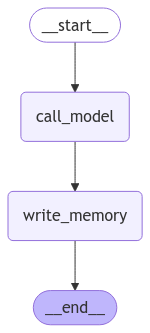

In [89]:
builder = StateGraph(ChatBotState)

builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

within_thread_memory = MemorySaver()
across_thread_memory = InMemoryStore()

graph = builder.compile(checkpointer = within_thread_memory, store = across_thread_memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [90]:
config = {"configurable" : {"user_id" : "11", "thread_id" : "12"}}

input_message = HumanMessage(content="Hi, my name is Hrithik")

for event in graph.stream({"messages":[input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Hrithik
*****************************CALL MODEL NODE*****************************
Existing Memory: None
Formatted Memory: None
---------------------------------------------------
Response: content='Hi Hrithik! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 72, 'total_tokens': 85, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None} id='run-18061c4a-81da-405d-9688-bc5395e872d9-0' usage_metadata={'input_tokens': 72, 'output_tokens': 13, 'total_tokens': 85, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_detail

In [91]:
user_id = "11"
namespace_for_memory = (user_id, "memory")
key = "user_memory"

existing_memory = across_thread_memory.get(namespace_for_memory, key)
pprint(existing_memory.value)

{'interests': [], 'location': '', 'user_name': 'Hrithik'}


In [92]:


input_message = HumanMessage(content="I like to bike around in Austin")

for event in graph.stream({"messages":[input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around in Austin
*****************************CALL MODEL NODE*****************************
Existing Memory: Item(namespace=['11', 'memory'], key='user_memory', value={'user_name': 'Hrithik', 'location': '', 'interests': []}, created_at='2025-01-07T06:44:01.234745+00:00', updated_at='2025-01-07T06:44:01.234745+00:00')
Formatted Memory: Name: Hrithik
Location: 
Interests: 

---------------------------------------------------
Response: content='That sounds great, Hrithik! Austin has some fantastic biking trails and scenic routes. Do you have any favorite trails or places you like to bike to?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 99, 'total_tokens': 132, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'au

In [93]:
config = {"configurable" : {"user_id" : "11", "thread_id" : "22"}}

input_message = HumanMessage(content="I also like to go to coffee shops after biking")

for event in graph.stream({"messages":[input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I also like to go to coffee shops after biking
*****************************CALL MODEL NODE*****************************
Existing Memory: Item(namespace=['11', 'memory'], key='user_memory', value={'user_name': 'Hrithik', 'location': 'Austin', 'interests': ['biking']}, created_at='2025-01-07T06:44:23.625215+00:00', updated_at='2025-01-07T06:44:23.625216+00:00')
Formatted Memory: Name: Hrithik
Location: Austin
Interests: biking

---------------------------------------------------
Response: content='That sounds like a great way to relax after a bike ride! Do you have a favorite coffee shop you like to visit?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 74, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'